In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from IPython.display import clear_output
# from qiskit_algorithms.optimizers import ADAM, COBYLA
# from qiskit_algorithms.optimizers import SPSA as qSPSA
from collections import Counter
import random
from qiskit import QuantumCircuit, qasm3, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import ParameterVector, Parameter
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import plot_histogram
# from qiskit_experiments.library.tomography import StateTomography

In [2]:
# function to encode a bit in a random basis
def encode_bit(bit): # bit is 0 or 1
    # Create a new quantum circuit with one qubit (and one classical bit to measure the qubit)
    qc = QuantumCircuit(1, 1)
    if bit == 1: # if the bit is 1, flip the qubit to |1> using 'NOT' (X) gate
        qc.x(0)
    basis = random.choice(["Z", "X"]) # randomly choose a basis
    if basis == "X": # if the basis is diagonal, apply Hadamard gate to collapse the qubit to |+> or |->
        qc.h(0)
    return qc, basis

In [3]:
n_bits = 50  # Number of bits to transmit
alice_bitstring = [random.randint(0, 1) for _ in range(n_bits)]
alice_bases = []
alice_states = []
for bit in alice_bitstring:
    state, basis = encode_bit(bit)
    alice_states.append(state)
    alice_bases.append(basis)

print("Alice's bits:", alice_bitstring)
print("Alice's bases:", alice_bases)

Alice's bits: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Alice's bases: ['Z', 'X', 'X', 'X', 'X', 'Z', 'X', 'Z', 'X', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'X', 'X', 'Z', 'X', 'Z', 'Z', 'Z', 'Z', 'X', 'X', 'X', 'Z', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'X', 'Z', 'X', 'Z', 'Z', 'Z', 'Z', 'X', 'X', 'Z', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'Z']


In [4]:
bob_bases = [random.choice(["Z", "X"]) for i in range(n_bits)]
print("Bob's bases:", bob_bases)

Bob's bases: ['X', 'X', 'Z', 'X', 'Z', 'X', 'X', 'X', 'Z', 'X', 'Z', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'X', 'X', 'X', 'Z', 'X', 'Z', 'Z', 'X', 'X', 'Z', 'X', 'X', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'X', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'Z', 'Z']


In [5]:
#  define a function that measures Alice's bit in the basis Bob received
def measure_bit(state, basis):
    # Apply the measurement basis
    if basis == "X":
        # Directly apply the Hadamard gate to the state vector
        qc = QuantumCircuit(1) # Create a new quantum circuit with one qubit
        qc.h(0) # Apply Hadamard gate to the qubit
        state = Statevector(state).evolve(qc) # Apply the Hadamard gate to the state vector
        qc.draw('mpl')
    # Calculate the probability of measuring |0> or |1>
    statevector = Statevector(state) # Convert the state to a state vector
    probabilities = statevector.probabilities_dict() # probabilities of measuring |0> and |1>
    prob_zero = probabilities.get('0', 0) # probability of measuring |0>
    prob_one = probabilities.get('1', 0)  # probability of measuring |1>
    return 0 if random.random() < prob_zero else 1 # randomly choose 0 or 1 based on the probabilities

bob_results = [measure_bit(alice_states[i], bob_bases[i]) for i in range(n_bits)] # measure each qubit in the basis Bob received from Alice
print("Bob's measurements of Alice's bit-string in his own basis:", bob_results)

Bob's measurements of Alice's bit-string in his own basis: [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [6]:
key_indices = [i for i in range(n_bits) if alice_bases[i] == bob_bases[i]] # indices where Alice and Bob used the same basis
alice_key = [alice_bitstring[i] for i in key_indices] 
bob_key = [bob_results[i] for i in key_indices]
print(key_indices)
print("Alice's final key:", alice_key)
print("Bob's final key:", bob_key)

[1, 3, 6, 9, 10, 11, 18, 20, 22, 24, 25, 26, 27, 29, 34, 35, 36, 37, 39, 40, 41, 45, 47, 48, 49]
Alice's final key: [0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Bob's final key: [0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]


In [7]:
agreement_consistency = sum([alice_key[i] == bob_key[i] for i in range(len(alice_key))]) / len(alice_key) # 
print("Key agreement rate:", agreement_consistency)

Key agreement rate: 1.0


In [8]:
eve_bases = [random.choice(["Z", "X"]) for _ in range(n_bits)]
eve_results = []

for i in range(n_bits):
    eve_result = measure_bit(alice_states[i], eve_bases[i])
    eve_results.append(eve_result)
    # Eve prepares a new state based on her measurement and basis
    qc = QuantumCircuit(1)
    if eve_result == 1: 
        qc.x(0) 
    if eve_bases[i] == "X":
        qc.h(0) 
    alice_states[i] = Statevector.from_instruction(qc)  # Update Alice's state with Eve's interference

bob_results_with_eve = [measure_bit(alice_states[i], bob_bases[i]) for i in range(n_bits)] # Bob measures the qubits he received from Alice
print("Bob's measurements after Eve:", bob_results_with_eve)
print("Alice's initial bits:", alice_bitstring)

Bob's measurements after Eve: [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Alice's initial bits: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [9]:
# detect eavesdropping
sample_indices = random.sample(range(len(key_indices)), len(key_indices) // 2) # randomly choose half of the indices where Alice and Bob used the same basis
mismatch_count = sum([alice_key[i] != bob_results_with_eve[i] for i in sample_indices]) # count the number of mismatches between Alice's key and Bob's key with Eve

if mismatch_count > 0:
    print("Eavesdropping detected.")
else:
    print("No eavesdropping detected.")

Eavesdropping detected.


In [10]:
# Step 1: Eavesdropping detection using a sample
sample_indices = random.sample(range(len(key_indices)), len(key_indices) // 2)
mismatch_count = sum([alice_key[i] != bob_results_with_eve[i] for i in sample_indices])

# Set an error rate threshold (e.g., 10%)
error_rate_threshold = 0.1
sample_size = len(sample_indices)
actual_error_rate = mismatch_count / sample_size

# Step 2: Determine if the error rate is acceptable
if actual_error_rate <= error_rate_threshold:
    print("Error rate within acceptable limits. Proceeding with the key.")
    # Retain only bits not in the sample, as they haven't been publicly compared
    secure_key = [alice_key[i] for i in range(len(alice_key)) if i not in sample_indices]
else:
    print("Error exceeds threshold. Applying privacy amplification.")
    # Privacy amplification: keep only part of the key to minimize Eve's possible information
    secure_key = [alice_key[i] for i in range(len(alice_key)) if i not in sample_indices]
    secure_key = secure_key[:len(secure_key) // 2]  # apply hash function; keep only half the bits

print("Error rate measured:", actual_error_rate)
print("Final, secure, agreed-upon key:", secure_key)

Error exceeds threshold. Applying privacy amplification.
Error rate measured: 0.6666666666666666
Final, secure, agreed-upon key: [1, 0, 1, 0, 0, 0]


In [11]:
def advanced_noise_model(p):

    noise_model = NoiseModel()

    amp_damp = amplitude_damping_error(p)
    noise_model.add_all_qubit_quantum_error(amp_damp, ['x', 'h'])

    depol = depolarizing_error(p, 1)
    noise_model.add_all_qubit_quantum_error(depol, ['x', 'h'])

    return noise_model

In [12]:
n_bits = 50

alice_bits = [random.randint(0, 1) for i in range(n_bits)] 
alice_bases = [random.choice(["Z", "X"]) for i in range(n_bits)]

bob_bases = [random.choice(["Z", "X"]) for i in range(n_bits)]
eve_bases = [random.choice(["Z", "X"]) for i in range(n_bits)]

In [13]:
# Alice's encoding
def Alice(i):
    qc = QuantumCircuit(1, 1) # simulate bb84 via quantum circuit
    if alice_bases[i] == "Z":
        # If Alice chooses Z basis:
        if alice_bits[i] == 1:
            qc.x(0)  # Apply X gate if the bit is 1
    elif alice_bases[i] == "X":
        # If Alice chooses X basis:
        if alice_bits[i] == 1:
            qc.x(0)  # Apply X gate to flip the qubit
        qc.h(0)  # Apply Hadamard to encode in the X basis
    qc.barrier()

    return qc


# print(DensityMatrix.from_instruction(qc))

# tomo_exp = StateTomography(qc)

# sim = AerSimulator()

# exp_data = tomo_exp.run(sim)

# exp_data.block_for_results()

# result = exp_data.analysis_results()

# rho = result[0].value

In [14]:
# Eve's measurements
def Eve(i):
    qce = QuantumCircuit(1, 1) # simulate bb84 via quantum circuit

    # Eve applies H only if her basis is X and Alice's basis was not X
    if eve_bases[i] == "X" and alice_bases[i] != "X":
        qce.h(0) # Apply Hadamard gate to the qubit
    qce.measure(0,0) # Measure the qubit and store the result in the classical bit
    qce.reset(0) # Reset the qubit to |0> state
    if eve_bases[i] == "X":
        qce.h(0) # Apply Hadamard gate to the qubit if her basis is X
    qce.barrier()
    qce.draw(output='mpl')
    return qce

In [15]:
# Bob's measurements
def Bob(i):
    qcb = QuantumCircuit(1, 1) # simulate bb84 via quantum circuit

    if bob_bases[i] == "X":
        qcb.h(0)  # Bob applies H if his basis is X
    qcb.measure(0, 0)
    qcb.barrier()
    qcb.draw(output='mpl')
    return qcb

In [16]:
from typing import List, Union

def bit_strings_a_vector_numerico(bit_data: Union[List[str], str]) -> np.ndarray:
    """
    Convierte una lista de strings de bits (o un solo string de bits) 
    a un array de NumPy de números enteros (0s y 1s).

    Args:
        bit_data: Lista de strings de bits (ej: ['0', '1', '1', '0']) o
                  un único string grande (ej: '0110').

    Returns:
        Un array de NumPy con los valores numéricos (np.int8) 
        correspondientes a los bits.
    """
    
    # 1. Asegurarse de que tenemos una lista de caracteres individuales
    if isinstance(bit_data, str):
        # Si es un solo string ('0110'), lo convierte en una lista de caracteres ['0', '1', '1', '0']
        data_list = list(bit_data)
    elif isinstance(bit_data, list):
        # Si ya es una lista de strings ['0', '1', '1', '0'], la usa directamente
        data_list = bit_data
    else:
        raise TypeError("El argumento debe ser un string o una lista de strings.")

    # 2. Convertir la lista de strings ('0', '1') a números enteros (0, 1) usando NumPy
    #    astype(np.int8) asegura que los números sean enteros de 8 bits.
    vector_numerico = np.array(data_list, dtype=np.int8)
    lista_con_comas = vector_numerico.tolist()

    return lista_con_comas

In [17]:
rate_1 = []
rate_2 = []
rate_3 = []
rate_4 = []
error_rate_1 = []
error_rate_2 = []
error_rate_3 = []
error_rate_4 = []

p = np.linspace(0, 0.1, 30)

for j in range(len(p)):
    a=p[j]
    sim_ideal = AerSimulator()
    sim_noise = AerSimulator(noise_model=advanced_noise_model(a))
    bob_results_eve = []
    bob_results_eve_noise = []

    for i in range(n_bits):
        qc = Alice(i)
        qce = Eve(i)
        qcb = Bob(i)

        bb84_eve = qc.compose(qce.compose(qcb))
        bb84_eve.draw('mpl')
        result_eve = sim_ideal.run(bb84_eve,shots=1).result()
        counts = result_eve.get_counts()
        bit_string = list(counts.keys())[0]
        bob_results_eve.append(bit_string)

        qc_noise = transpile(qc,backend=sim_noise)
        qcb_noise = transpile(qcb,backend=sim_noise)

        bb84_eve_noise = qc_noise.compose(qce.compose(qcb_noise))
        result_eve = sim_noise.run(bb84_eve_noise,shot=1).result()
        counts = result_eve.get_counts()
        bit_string = list(counts.keys())[0]
        bob_results_eve_noise.append(bit_string)


    bob_results = []
    bob_results_noise = []

    for i in range(n_bits):
        qc = Alice(i)
        qcb = Bob(i)

        bb84 = qc.compose(qcb)
        result = sim_ideal.run(bb84,shots=1).result()
        counts = result.get_counts()
        bit_string = list(counts.keys())[0]
        bob_results.append(bit_string)

        qc_noise = transpile(qc,backend=sim_noise)
        qcb_noise = transpile(qcb,backend=sim_noise)

        bb84_noise = qc_noise.compose(qce.compose(qcb_noise))
        result = sim_noise.run(bb84_noise,shot=1).result()
        counts = result.get_counts()
        bit_string = list(counts.keys())[0]
        bob_results_noise.append(bit_string)
        

    bob_results_eve_vector=bit_strings_a_vector_numerico(bob_results_eve)
    bob_results_eve_noise_vector=bit_strings_a_vector_numerico(bob_results_eve_noise)
    bob_results_vector=bit_strings_a_vector_numerico(bob_results)
    bob_results_noise_vector=bit_strings_a_vector_numerico(bob_results_noise)

    key_indices = [i for i in range(n_bits) if alice_bases[i] == bob_bases[i]] # indices where Alice and Bob used the same basis
    alice_key = [alice_bits[i] for i in key_indices] 
    bob_key1 = [bob_results_eve_vector[i] for i in key_indices]
    bob_key2 = [bob_results_eve_noise_vector[i] for i in key_indices]
    bob_key3 = [bob_results_vector[i] for i in key_indices]
    bob_key4 = [bob_results_noise_vector[i] for i in key_indices]


    agreement_consistency1 = sum([alice_key[i] == bob_key1[i] for i in range(len(alice_key))]) / len(alice_key) # 
    agreement_consistency2 = sum([alice_key[i] == bob_key2[i] for i in range(len(alice_key))]) / len(alice_key) # 
    agreement_consistency3 = sum([alice_key[i] == bob_key3[i] for i in range(len(alice_key))]) / len(alice_key) # 
    agreement_consistency4 = sum([alice_key[i] == bob_key4[i] for i in range(len(alice_key))]) / len(alice_key) # 

    rate_1.append(agreement_consistency1)
    rate_2.append(agreement_consistency2)
    rate_3.append(agreement_consistency3)
    rate_4.append(agreement_consistency4)

    # Step 1: Eavesdropping detection using a sample
    sample_indices = random.sample(range(len(key_indices)), len(key_indices) // 2)
    mismatch_count1 = sum([alice_key[i] != bob_results_eve_vector[i] for i in sample_indices])
    mismatch_count2 = sum([alice_key[i] != bob_results_eve_noise_vector[i] for i in sample_indices])
    mismatch_count3 = sum([alice_key[i] != bob_results_vector[i] for i in sample_indices])
    mismatch_count4 = sum([alice_key[i] != bob_results_noise_vector[i] for i in sample_indices])

    # Set an error rate threshold (e.g., 10%)
    error_rate_threshold = 0.1
    sample_size = len(sample_indices)
    actual_error_rate1 = mismatch_count1 / sample_size
    actual_error_rate2 = mismatch_count2 / sample_size
    actual_error_rate3 = mismatch_count3 / sample_size
    actual_error_rate4 = mismatch_count4 / sample_size


    error_rate_1.append(actual_error_rate1)
    error_rate_2.append(actual_error_rate2)
    error_rate_3.append(actual_error_rate3)
    error_rate_4.append(actual_error_rate4)
    print(j)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28
29


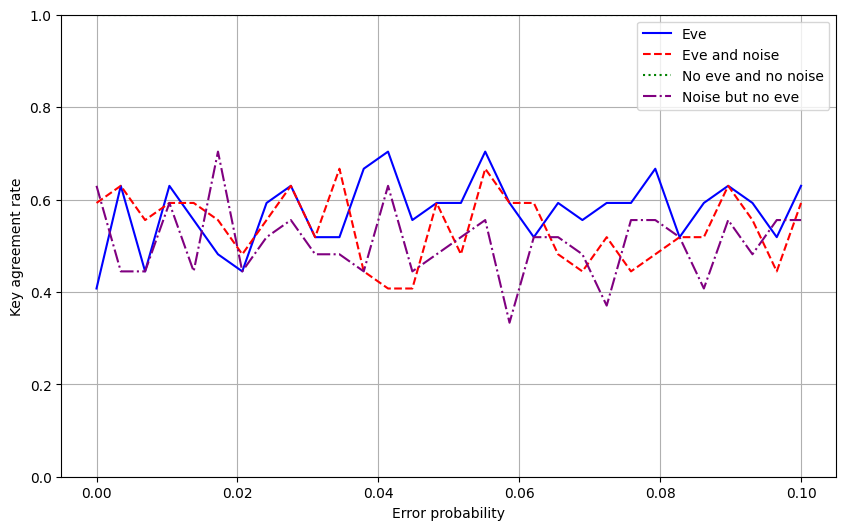

In [18]:
# 1. Generar datos de ejemplo
# Creamos el eje X común para todas las gráficas
x = p # 500 puntos entre 0 y 10

# Creamos las 4 series de datos (Eje Y)
y1 = rate_1                 # Onda seno
y2 = rate_2                 # Onda coseno
y3 = rate_3 # Onda amortiguada
y4 = rate_4               # Línea recta

# 2. Crear el Plot
plt.figure(figsize=(10, 6)) # Define el tamaño de la figura

# Dibuja las 4 gráficas, una tras otra, en el mismo eje
plt.plot(x, y1, label= 'Eve', color='blue', linestyle='-')
plt.plot(x, y2, label='Eve and noise', color='red', linestyle='--')
plt.plot(x, y3, label='No eve and no noise', color='green', linestyle=':')
plt.plot(x, y4, label='Noise but no eve', color='purple', linestyle='-.')

# 3. Personalización y Títulos
plt.xlabel('Error probability')
plt.ylabel('Key agreement rate')
plt.ylim(0, 1)
# Muestra la leyenda (esencial para diferenciar las series)
plt.legend()

# Añade una rejilla para mejor lectura (opcional)
plt.grid(True)

# Muestra el gráfico
plt.show()

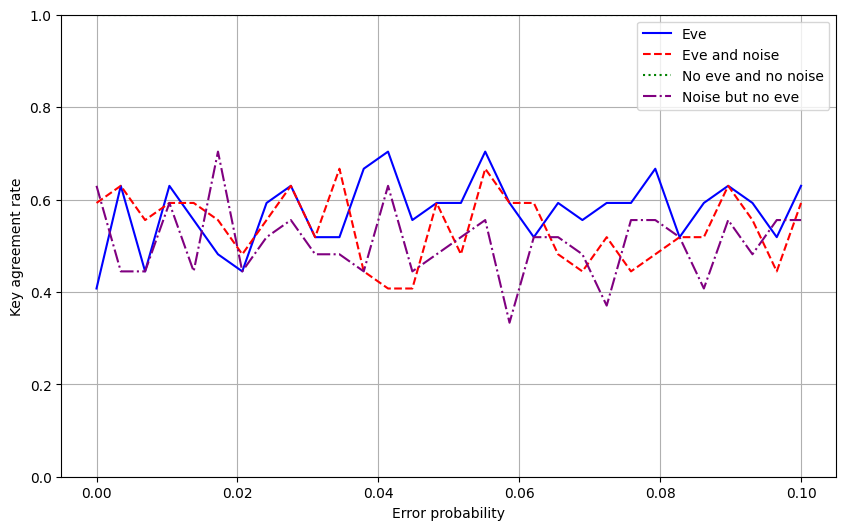

In [19]:
# 1. Generar datos de ejemplo
# Creamos el eje X común para todas las gráficas
x = p # 500 puntos entre 0 y 10

# Creamos las 4 series de datos (Eje Y)
y1 = rate_1                 # Onda seno
y2 = rate_2                 # Onda coseno
y3 = rate_3 # Onda amortiguada
y4 = rate_4               # Línea recta

# 2. Crear el Plot
plt.figure(figsize=(10, 6)) # Define el tamaño de la figura

# Dibuja las 4 gráficas, una tras otra, en el mismo eje
plt.plot(x, y1, label= 'Eve', color='blue', linestyle='-')
plt.plot(x, y2, label='Eve and noise', color='red', linestyle='--')
plt.plot(x, y3, label='No eve and no noise', color='green', linestyle=':')
plt.plot(x, y4, label='Noise but no eve', color='purple', linestyle='-.')

# 3. Personalización y Títulos
plt.xlabel('Error probability')
plt.ylabel('Key agreement rate')
plt.ylim(0, 1)
# Muestra la leyenda (esencial para diferenciar las series)
plt.legend()

# Añade una rejilla para mejor lectura (opcional)
plt.grid(True)

# Muestra el gráfico
plt.show()

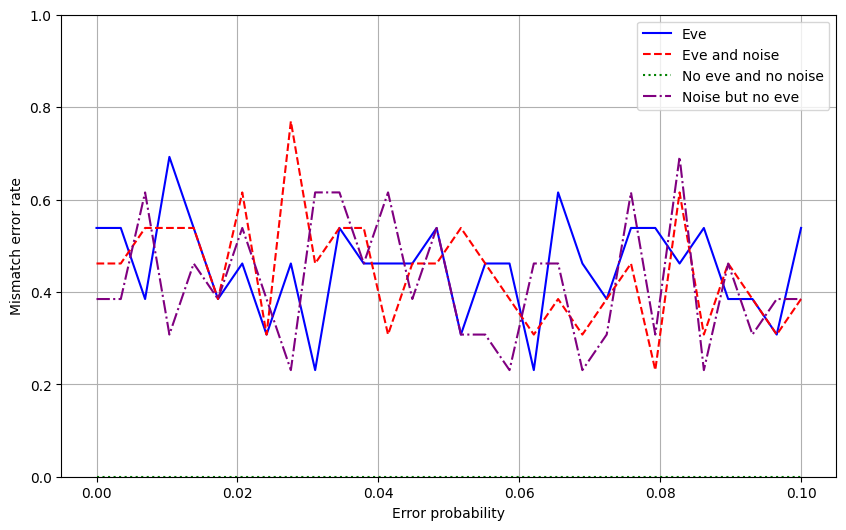

In [20]:
# 1. Generar datos de ejemplo
# Creamos el eje X común para todas las gráficas
x = p # 500 puntos entre 0 y 10

# Creamos las 4 series de datos (Eje Y)
y1 = error_rate_1                 # Onda seno
y2 = error_rate_2                 # Onda coseno
y3 = np.zeros(len(rate_1)) # Onda amortiguada
y4 = error_rate_4               # Línea recta

# 2. Crear el Plot
plt.figure(figsize=(10, 6)) # Define el tamaño de la figura

# Dibuja las 4 gráficas, una tras otra, en el mismo eje
plt.plot(x, y1, label= 'Eve', color='blue', linestyle='-')
plt.plot(x, y2, label='Eve and noise', color='red', linestyle='--')
plt.plot(x, y3, label='No eve and no noise', color='green', linestyle=':')
plt.plot(x, y4, label='Noise but no eve', color='purple', linestyle='-.')

# 3. Personalización y Títulos
plt.xlabel('Error probability')
plt.ylabel('Mismatch error rate')
plt.ylim(0, 1)
# Muestra la leyenda (esencial para diferenciar las series)
plt.legend()

# Añade una rejilla para mejor lectura (opcional)
plt.grid(True)

# Muestra el gráfico
plt.show()